In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [2]:
import pandas as pd
import numpy as np

# Data Aggregation in Pandas

Often we will be interested in groups, patterns, and trends in our data rather than the individual data points themselves. *Aggregation* refers to the process of summarizing a data set. This could involve the calculation of statistics, picking out a representative point from a group of similar points, calculating a histogram, or something more complex.

We're consider different aggregations by exploring a data set of mortgage insurance issued by the Federal Housing Authority (FHA).  The data is broken down by census tract and tells us how big of a player the FHA is in each tract (how many homes etc.).

In [44]:
names = ["State_Code", "County_Code", "Census_Tract_Number", "NUM_ALL",
        "NUM_FHA", "PCT_NUM_FHA", "AMT_ALL", "AMT_FHA", "PCT_AMT_FHA"]
# Loading a CSV file, without a header (so we have to provide field names)
df = pd.read_csv('small_data/fha_by_tract.csv', names=names)
df.head()

,State_Code,County_Code,Census_Tract_Number,NUM_ALL,NUM_FHA,PCT_NUM_FHA,AMT_ALL,AMT_FHA,PCT_AMT_FHA
0,8.0,75.0,NaN,1,1,100.0,258,258,100.0
1,28.0,49.0,103.01,1,1,100.0,71,71,100.0
2,40.0,3.0,NaN,1,1,100.0,215,215,100.0
3,39.0,113.0,603.00,3,3,100.0,206,206,100.0
4,12.0,105.0,124.04,2,2,100.0,303,303,100.0


## Basic statistics and visualization


As a first step in exploring a new data set, we'll often examine quartile statistics or make simple visualizations of the distribution of the data.

In [4]:
print "Percentage of mortages in each census tract insured by FHA"
df['PCT_AMT_FHA'].describe()

Percentage of mortages in each census tract insured by FHA


count    72035.000000
mean        29.703179
std         24.037779
min          0.000000
25%         10.780800
50%         24.753900
75%         44.207550
max        100.000000
Name: PCT_AMT_FHA, dtype: float64

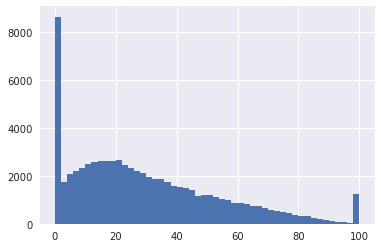

In [8]:
df['PCT_AMT_FHA'].hist(bins=50)

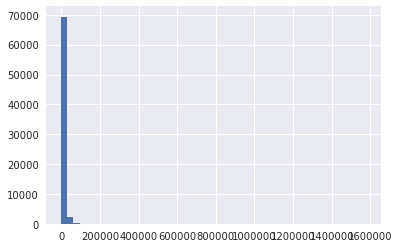

In [9]:
df['AMT_ALL'].hist(bins=50)

The above distribution looks skewed, so let's look at its logarithm.

count    72035.000000
mean         8.170124
std          1.429644
min          1.098612
25%          7.347300
50%          8.335431
75%          9.176680
max         14.270319
Name: LOG_AMT_ALL, dtype: float64


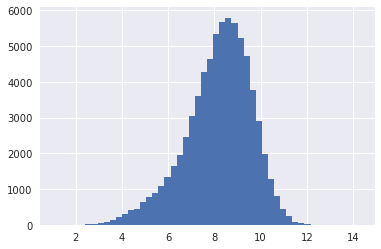

In [10]:
df['LOG_AMT_ALL'] = np.log1p(df['AMT_ALL'])  # Create a new column to examine
print df['LOG_AMT_ALL'].describe()

df['LOG_AMT_ALL'].hist(bins=50)

**Exercise:**

1. Notice that there is a spike in the histogram of PCT_AMT_FHA at 100%.  This means that the FHA has insured 100% of the houses in that census tract.  See what happens to the histogram when we restrict it to the case where the total number of loans (AMT_ALL) is non-negligible.
2. Plot the histogram of PCT_AMT_FHA for two different states in the same graph to compare them.
3. Create a new column QT_AMT_FHA, that shows the quartile of PCT_AMT_FHA.
4. Select the census tracts in top quartile for PCT_AMT_FHA. Plot a bar chart of how many times each State_Code appears in the results.

## Aggregating data by group


The analog of SQL's `GROUP BY` is

```python
grouped = df.groupby(['field_name1', ...])...
```

The above is analogous to

```sql
SELECT ...
FROM df
GROUP BY df.field_name1, ...
```

Pandas is somewhat more flexible in how you can use grouping, not requiring you to specify an aggregation function up front.  The `.groupby()` method that can later be aggregated.

In [39]:
df['GEOID'] = (df['Census_Tract_Number']*100 + 10**6 * df['County_Code']
               + 10**9 * df['State_Code'])   # A computed field!
df_geo = pd.read_csv('small_data/2013_Gaz_tracts_national.tsv', sep='\t')
df_joined = df.merge(df_geo, on='GEOID', how='left')

usps_groups = df_joined.groupby('USPS')
usps_groups

The reason Pandas doesn't require you to specify an aggregation function up front is because the `groupby()` method by itself does little work. It returns a `DataFrameGroupBy` data type that contains a dictionary of group keys to lists of row numbers.

In [43]:
print type(usps_groups.groups)
usps_groups.groups['AK'][:5]

<type 'dict'>


Int64Index([91, 298, 536, 2528, 4146], dtype='int64')

We can retrieve the group of data associated with one key:

In [16]:
usps_groups.get_group('AK').head()

,State_Code,County_Code,Census_Tract_Number,NUM_ALL,NUM_FHA,PCT_NUM_FHA,AMT_ALL,AMT_FHA,PCT_AMT_FHA,LOG_AMT_ALL,GEOID,USPS,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
91,2.0,50.0,3.0,1,1,100.0000,121,121,100.0000,4.804021,2.05e+09,AK,4.930719e+10,6.258804e+08,19037.615,241.654,61.468804,-156.692206
298,2.0,20.0,4.0,1,1,100.0000,192,192,100.0000,5.262690,2.02e+09,AK,5.336808e+07,2.393787e+07,20.606,9.242,61.266668,-149.830858
536,2.0,122.0,1.0,1,1,100.0000,39,39,100.0000,3.688879,2.122e+09,AK,1.982658e+10,1.006239e+10,7655.087,3885.112,60.123779,-152.841141
2528,2.0,185.0,1.0,11,8,72.7273,1958,1604,81.9203,7.580189,2.185e+09,AK,2.532416e+08,3.781985e+08,97.777,146.023,71.287938,-156.685618
4146,2.0,122.0,12.0,3,2,66.6667,530,392,73.9623,6.274762,2.122e+09,AK,2.498757e+09,4.721135e+09,964.775,1822.840,59.356474,-151.771450


Observe that this is the same as:

In [20]:
df_joined.iloc[usps_groups.groups['AK'][:5]]

,State_Code,County_Code,Census_Tract_Number,NUM_ALL,NUM_FHA,PCT_NUM_FHA,AMT_ALL,AMT_FHA,PCT_AMT_FHA,LOG_AMT_ALL,GEOID,USPS,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
91,2.0,50.0,3.0,1,1,100.0000,121,121,100.0000,4.804021,2.05e+09,AK,4.930719e+10,6.258804e+08,19037.615,241.654,61.468804,-156.692206
298,2.0,20.0,4.0,1,1,100.0000,192,192,100.0000,5.262690,2.02e+09,AK,5.336808e+07,2.393787e+07,20.606,9.242,61.266668,-149.830858
536,2.0,122.0,1.0,1,1,100.0000,39,39,100.0000,3.688879,2.122e+09,AK,1.982658e+10,1.006239e+10,7655.087,3885.112,60.123779,-152.841141
2528,2.0,185.0,1.0,11,8,72.7273,1958,1604,81.9203,7.580189,2.185e+09,AK,2.532416e+08,3.781985e+08,97.777,146.023,71.287938,-156.685618
4146,2.0,122.0,12.0,3,2,66.6667,530,392,73.9623,6.274762,2.122e+09,AK,2.498757e+09,4.721135e+09,964.775,1822.840,59.356474,-151.771450


In [21]:
usps_groups.mean().head()  # Takes the mean of the rows in each group

,State_Code,County_Code,Census_Tract_Number,NUM_ALL,NUM_FHA,PCT_NUM_FHA,AMT_ALL,AMT_FHA,PCT_AMT_FHA,LOG_AMT_ALL,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
USPS,,,,,,,,,,,,,,,,
AK,2.0,98.357616,9.449338,49.079470,12.251656,27.172880,12450.741722,2905.072848,27.456326,8.791516,4.658549e+09,9.506639e+08,1798.675881,367.053397,61.124912,-148.239871
AL,1.0,75.836331,1889.544523,32.163669,8.333633,28.754330,5189.795863,1112.598022,29.368947,7.607937,1.132807e+08,2.623693e+06,43.737926,1.013006,32.961141,-86.761186
AR,5.0,78.663690,3196.877113,37.946429,8.427083,21.377452,5377.254464,1105.171131,22.321766,7.848935,1.981421e+08,4.362258e+06,76.503085,1.684271,35.078429,-92.548487
AZ,4.0,14.893676,2446.197818,52.276581,15.538568,33.198714,9571.252259,2425.145935,34.168339,8.423604,1.443226e+08,6.508373e+05,55.723284,0.251290,33.315336,-111.890482
CA,6.0,54.777636,2005.292730,39.154278,11.303073,29.568614,12726.953972,2882.465766,32.965875,8.887090,4.902491e+07,8.379937e+05,18.928632,0.323551,35.504532,-119.414014


In [22]:
# This is the analog of
# SELECT USPS, SUM(AMT_FHA), SUM(AMT_ALL), ... FROM df GROUP BY USPS;
df_by_state = usps_groups['AMT_FHA', 'AMT_ALL', 'NUM_FHA', 'NUM_ALL'].sum()
df_by_state.head()

,AMT_FHA,AMT_ALL,NUM_FHA,NUM_ALL
USPS,,,,
AK,438666,1880062,1850,7411
AL,1237209,5771053,9267,35766
AR,742675,3613515,5663,25500
AZ,3489785,13773032,22360,75226
CA,22607179,99817500,88650,307087


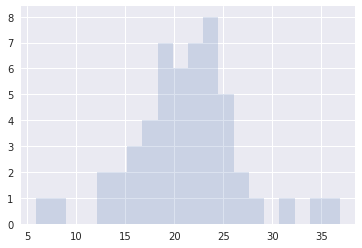

In [23]:
df_by_state['PCT_AMT_FHA'] = 100.0 * df_by_state['AMT_FHA']  / df_by_state['AMT_ALL']

# This sure looks different than the census-tract level histogram!
df_by_state['PCT_AMT_FHA'].hist(bins=20, alpha=.2)

You can also specify a specific aggregation function per column:

In [24]:
usps_groups['NUM_FHA', 'NUM_ALL'].agg({'NUM_FHA': np.sum,
                                       'NUM_ALL': np.mean}).head()

,NUM_ALL,NUM_FHA
USPS,,
AK,49.079470,1850
AL,32.163669,9267
AR,37.946429,5663
AZ,52.276581,22360
CA,39.154278,88650


The `groupby()` function is especially useful when you define your own aggregation functions. Here, we define a function that returns the row for the census track located farthest to the north. The apply function attempts to 'combine results together in an intelligent way.' The list of Series objects from each call to `farthest_north` for each USPS code is collapsed into a single DataFrame table.

In [25]:
def farthest_north(state_df):
    # descending sort, then select row 0
    # the data type will be a pandas Series
    return state_df.sort_values('INTPTLAT', ascending=False).iloc[0]

df_joined.groupby('USPS').apply(farthest_north)[:10]

,State_Code,County_Code,Census_Tract_Number,NUM_ALL,NUM_FHA,PCT_NUM_FHA,AMT_ALL,AMT_FHA,PCT_AMT_FHA,LOG_AMT_ALL,GEOID,USPS,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
USPS,,,,,,,,,,,,,,,,,,
AK,2.0,185.0,1.00,11,8,72.72730,1958,1604,81.92030,7.580189,2.185000e+09,AK,2.532416e+08,378198536.0,97.777,146.023,71.287938,-156.685618
AL,1.0,71.0,9502.00,10,2,20.00000,700,216,30.85710,6.552508,1.071950e+09,AL,9.275512e+07,2986584.0,35.813,1.153,34.965286,-85.777448
AR,5.0,7.0,208.03,91,9,9.89011,9673,909,9.39729,9.177197,5.007021e+09,AR,1.397141e+07,295088.0,5.394,0.114,36.486278,-94.283383
AZ,4.0,5.0,21.00,38,10,26.31580,7078,1831,25.86890,8.864888,4.005002e+09,AZ,5.956008e+07,4650137.0,22.996,1.795,36.916588,-111.470183
CA,6.0,93.0,4.00,2,0,0.00000,741,0,0.00000,6.609349,6.093000e+09,CA,5.329775e+08,3118247.0,205.784,1.204,41.946648,-122.634808
CO,8.0,75.0,9659.00,5,0,0.00000,388,0,0.00000,5.963579,8.075966e+09,CO,1.425537e+09,3036714.0,550.403,1.172,40.924098,-103.073557
CT,9.0,3.0,5243.00,46,16,34.78260,6441,2580,40.05590,8.770594,9.003524e+09,CT,1.314194e+07,242922.0,5.074,0.094,42.024605,-72.530403
DC,11.0,1.0,16.00,41,10,24.39020,23623,6368,26.95680,10.070018,1.100100e+10,DC,2.650934e+06,35617.0,1.024,0.014,38.984972,-77.038232
DE,10.0,3.0,112.02,23,9,39.13040,5656,2370,41.90240,8.640649,1.000301e+10,DE,3.704573e+06,0.0,1.430,0.000,39.832216,-75.521217


**Exercise:**

1. Compute the mean land area for each PCT_AMT_FHA quartile. Is there a trend?
2. What is the PCT_AMT_FHA in the census tract with the largest land area in each state?

## DataFrame Resampling


We will sometimes work with time series data, where we have measurements of some fields at different points in time. Pandas DataFrames provide a resampling method for changing the sampling frequency of your data. Perhaps you have daily data but only care about the data at monthly intervals. You can resample to reduce the sampling frequency.

In [26]:
year2016 = pd.date_range(start='1/1/2016', end='12/31/2016')

daily_data_df = pd.DataFrame(np.random.rand(len(year2016)), index=year2016, columns=['random'])
daily_data_df.head()

,random
2016-01-01,0.385241
2016-01-02,0.737315
2016-01-03,0.532228
2016-01-04,0.266999
2016-01-05,0.978159


This makes a new DataFrame with each data-point coming from the last day of the month.

In [34]:
monthly_data = daily_data_df.resample('1M').last()
monthly_data

,random
2016-01-31,0.584717
2016-02-29,0.463835
2016-03-31,0.678563
2016-04-30,0.077615
2016-05-31,0.969494
2016-06-30,0.093860
2016-07-31,0.228273
2016-08-31,0.692447
2016-09-30,0.209608
2016-10-31,0.626173


This syntax of `df.resample(...).last()` follows the same syntax as `df.groupby(...).apply(...)` because the two operations are very similar. When we downsample from daily to monthly, all the data points in a given month are grouped together. We then aggregate them by applying the `last` method, which simply picks the last data point in the group. We could alternatively aggregate the monthly groups by taking a mean, a max, a median, etc.

What about resampling in the other direction? This is possible, but you may have gaps in the result. To avoid this, use the `ffill` and `bfill` methods, like so.

In [ ]:
daily_data2 = monthly_data.resample('1D').bfill()
daily_data2.head()

You'll also notice that the first date in that DataFrame is 2016-01-31, not 2016-01-01 like in the original list. We can fix that if we want to. The `loc[year2016]` code fixes the index and the `bfill()` fills in the January values.

In [ ]:
daily_data3 = daily_data2.loc[year2016].bfill()
daily_data3.head()

**Exercise:**

1. Resample the daily data to monthly data, using the mean value of each month.
2. Resample the daily data to quarterly data, using the maximum value of each quarter.
3. Identify the day that had the maximum value in each quarter.

*Copyright &copy; 2018 The Data Incubator.  All rights reserved.*